# HW4 problem 2

Seokjun Choi

*Code blocks are Python scripts in this problem.*

*Executable stand-alone Python script: https://github.com/letsjdosth/GLM/blob/main/hw4q2.py*

*This code depends on third-party packages*
- numpy
- matplotlib

and another python module that I implemented,
- MCMC_Core: *https://github.com/letsjdosth/GLM/blob/main/pyBayes/MCMC_Core.py*

*All scripts are tested in Python 3.10.5 64-bit, in Windows 10.*


Let me start with defining functions that I will use for sub-questions.

In [10]:
from random import seed, normalvariate
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from pyBayes import MCMC_Core

seed(20221119)

#data
class AlligatorFoodChoice:
    def __init__(self) -> None:
        male_string = "1.30,I;1.80,F;1.32,F;1.85,F;1.32,F;1.93,I;1.40,F;1.93,F;1.42,I;1.98,I;1.42,F;2.03,F;1.47,I;2.03,F;1.47,F;2.31,F;1.50,I;2.36,F;1.52,I;2.46,F;1.63,I;3.25,O;1.65,O;3.28,O;1.65,O;3.33,F;1.65,I;3.56,F;1.65,F;3.58,F;1.68,F;3.66,F;1.70,I;3.68,O;1.73,O;3.71,F;1.78,F;3.89,F;1.78,O"
        female_string="1.24,I;2.56,O;1.30,I;2.67,F;1.45,I;2.72,I;1.45,O;2.79,F;1.55,I;2.84,F;1.60,I;1.60,I;1.65,F;1.78,I;1.78,O;1.80,I;1.88,I;2.16,F;2.26,F;2.31,F;2.36,F;2.39,F;2.41,F;2.44,F"
        male_split = [tuple(i.split(",")) for i in male_string.split(";")]
        female_split = [tuple(i.split(",")) for i in female_string.split(";")]

        self.y_length_gender = [(choice, float(length), 0) for length, choice in male_split] + [(choice, float(length), 1) for length, choice in female_split]
        self.y_length = [(choice, float(length)) for length, choice in male_split] + [(choice, float(length)) for length, choice in female_split]
        #gender: 0: male, 1: female


data_inst = AlligatorFoodChoice()
# print(data_inst.y_length)


def symmetric_proposal_placeholder(from_smpl, to_smpl):
    #for log_proposal
    return 0

def normal_proposal_sampler(from_smpl, proposal_sigma_vec):
    return [normalvariate(x, proposal_sigma_vec[i]) for i,x in enumerate(from_smpl)]

def log_posterior_with_flat_prior(beta, y_x):
    #beta: [beta_I_0, beta_I_1, (beta_I_2), beta_O_1, beta_O_2, (beta_O,2)]
    beta_dim = len(beta)//2
    beta_I = np.array(beta[0:beta_dim], dtype=float)
    beta_O = np.array(beta[beta_dim:len(beta)], dtype=float)
    
    log_post = 0
    for pt in y_x:
        y = pt[0]
        x = np.array([1]+list(pt[1:]), dtype=float)
        log_post -= np.log(1 + np.exp(np.dot(x, beta_I)) + np.exp(np.dot(x, beta_O)))
        if y == 'I':
            log_post += np.dot(x, beta_I)
        elif y == 'O':
            log_post += np.dot(x, beta_O)
        else:
            log_post += 0
    return log_post

def log_posterior_with_normal_prior(beta, y_x, sigma_vec):
    log_post = log_posterior_with_flat_prior(beta, y_x)
    log_post -= sum([b**2/(2*s**2) for b,s in zip(beta, sigma_vec)])
    return log_post

def pi_plot(posterior_samples, set_x_axis, gender=None, show=True): #depend on data (not first-class function!)
    beta_dim = len(posterior_samples[0])//2
    
    x_grid = np.arange(set_x_axis[0], set_x_axis[1], set_x_axis[2])
    pi1_lwr = [] #I
    pi1_med = []
    pi1_upr = []
    pi1_avg = []
    pi2_lwr = [] #O
    pi2_med = []
    pi2_upr = []
    pi2_avg = []
    pi3_lwr = [] #F
    pi3_med = []
    pi3_upr = []
    pi3_avg = []
    for x in x_grid:
        pi1_samples_at_x = []
        pi2_samples_at_x = []
        pi3_samples_at_x = []
        x_with_1 = None
        if gender is None:
            x_with_1 = np.array([1, x], dtype=float)
        elif gender==0:
            x_with_1 = np.array([1, x, 0], dtype=float)
        else: #gender==1
            x_with_1 = np.array([1, x, 1], dtype=float)

        for beta in posterior_samples:
            beta_I = np.array(beta[0:beta_dim], dtype=float)
            beta_O = np.array(beta[beta_dim:len(beta)], dtype=float)
            denom = 1+np.exp(np.dot(x_with_1, beta_I))+np.exp(np.dot(x_with_1, beta_O))

            pi1_samples_at_x.append(np.exp(np.dot(x_with_1, beta_I))/denom)
            pi2_samples_at_x.append(np.exp(np.dot(x_with_1, beta_O))/denom)
            pi3_samples_at_x.append(1/denom)

        pi1_lwr.append(float(np.quantile(pi1_samples_at_x, 0.025)))
        pi1_med.append(float(np.quantile(pi1_samples_at_x, 0.5)))
        pi1_upr.append(float(np.quantile(pi1_samples_at_x, 0.975)))
        pi1_avg.append(float(np.mean(pi1_samples_at_x)))
        pi2_lwr.append(float(np.quantile(pi2_samples_at_x, 0.025)))
        pi2_med.append(float(np.quantile(pi2_samples_at_x, 0.5)))
        pi2_upr.append(float(np.quantile(pi2_samples_at_x, 0.975)))
        pi2_avg.append(float(np.mean(pi2_samples_at_x)))
        pi3_lwr.append(float(np.quantile(pi3_samples_at_x, 0.025)))
        pi3_med.append(float(np.quantile(pi3_samples_at_x, 0.5)))
        pi3_upr.append(float(np.quantile(pi3_samples_at_x, 0.975)))
        pi3_avg.append(float(np.mean(pi3_samples_at_x)))

    plt.ylim([0, 1.05])
    plt.plot(x_grid, pi1_avg, color="black", linestyle="solid") #I
    plt.plot(x_grid, pi1_med, color="black", linestyle="dashed")
    plt.plot(x_grid, pi1_lwr, color="grey")
    plt.plot(x_grid, pi1_upr, color="grey")
    plt.plot(x_grid, pi2_avg, color="red", linestyle="solid") #O
    plt.plot(x_grid, pi2_med, color="red", linestyle="dashed")
    plt.plot(x_grid, pi2_lwr, color="grey")
    plt.plot(x_grid, pi2_upr, color="grey")
    plt.plot(x_grid, pi3_avg, color="blue", linestyle="solid") #F
    plt.plot(x_grid, pi3_med, color="blue", linestyle="dashed")
    plt.plot(x_grid, pi3_lwr, color="grey")
    plt.plot(x_grid, pi3_upr, color="grey")
    
    if show:
        plt.show()


# 2-(a)

Here, I use 'length' as a covariate.
Please see the attached note for details.

For prior distribution, I use a vague normal distribution, specifically $(\beta_{I0}, \beta_{I1}, \beta_{O0}, \beta_{O1} \sim N((0,0,0,0), diag(10^2, 10^2, 10^2, 10^2)))$. This is because we don't have any prior information.

For MCMC iteration, I use a 4-dimensional multivariate normal distribution as a proposal distribution.

estimated running time:  0.0 min  45.39787769317627 sec
iteration 10000 / 50000
iteration 20000 / 50000
iteration 30000 / 50000
iteration 40000 / 50000
iteration 50000 / 50000  done! (elapsed time for execution:  0.0 min  44.755420446395874 sec)
acceptance rate:  0.1743


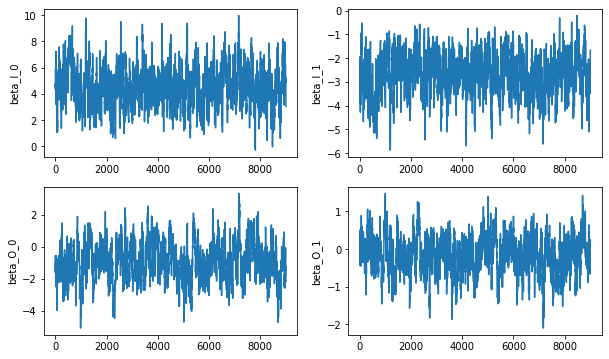

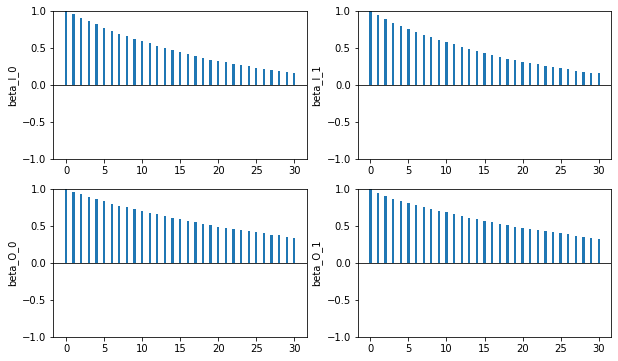

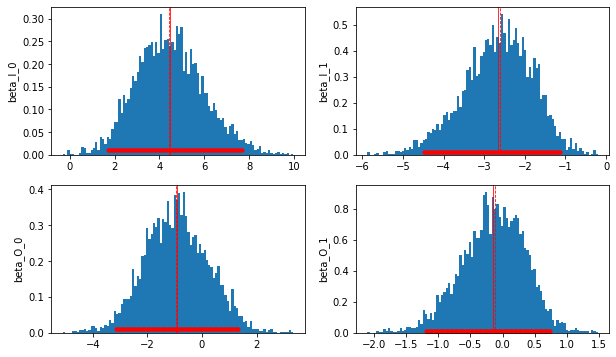

param 		 mean 	 var 	 95%CI
beta_I_0 		 4.478208 	 2.326577 	 [1.691389, 7.676337]
beta_I_1 		 -2.655474 	 0.732416 	 [-4.477868, -1.141811]
beta_O_0 		 -0.93292 	 1.359785 	 [-3.165488, 1.336894]
beta_O_1 		 -0.146817 	 0.244359 	 [-1.189077, 0.734488]


In [11]:
# # 2a
length_initial = [0,0,0,0]
length_inst = MCMC_Core.MCMC_MH(
                partial(log_posterior_with_normal_prior, y_x=data_inst.y_length, sigma_vec=(10,10,10,10)),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[0.6, 0.6, 0.4, 0.25]),
                length_initial)
length_inst.generate_samples(50000, print_iter_cycle=10000)
length_diag = MCMC_Core.MCMC_Diag()
length_diag.set_mc_sample_from_MCMC_instance(length_inst)
length_diag.set_variable_names(["beta_I_0", "beta_I_1", "beta_O_0", "beta_O_1"])
length_diag.burnin(5000)
length_diag.thinning(5)

length_diag.show_traceplot((2,2))
length_diag.show_acf(30, (2,2))
length_diag.show_hist((2,2))
length_diag.print_summaries(6)

The above plots are traceplots, acf plots, and histograms(with mean/median(vertical red line/dashed lines) and 95% credible interval(horizontal red line)) for all parameters (please y-axis labels for names of the parameters.)
The table shows posterior means, variances, and 95% (centered) credible intervals based on the generated samples.

We can interpret the results using log-odd ratios following the baseline category logits' definition, but the more intuitive way is to plot fitted $\pi$ s.

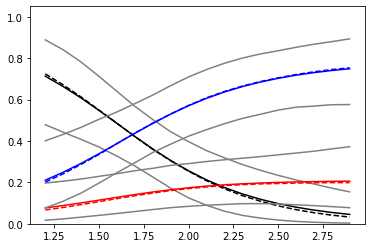

In [12]:
pi_plot(length_diag.MC_sample, (1.2, 3.0, 0.1), None)

In the pi-plot, the black solid/dashed curves are posterior mean/median of $\pi_I$, the reds are of $\pi_O$, and the blues are of $\pi_F$. Gray curves are 95% credible intervals' bounds. The horizontal axis is 'length', and the vertical axis indicates $\pi$.

As alligators' length (covariate) increases, alligators are unlikely to choose invertebrates as their food. 
The other two categories' probabilities increase with their length, and the possibility of selecting 'fish' is higher than 'others.'

## 2-(b)

Now, I use both 'length' and 'gender' as covariates.
Again, please see the note for details.

I set a vague prior distribution $(\beta_{I0},\beta_{I1},\beta_{I2},\beta_{O0},\beta_{O0},\beta_{O0}) \sim N(0, diag(10^2, 10^2, 10^2, 10^2, 10^2, 10^2))$, because we don't have any prior information.

I set multivariate normal distribution again for the proposal in each MCMC step.

estimated running time:  0.0 min  52.90257930755615 sec
iteration 10000 / 50000
iteration 20000 / 50000
iteration 30000 / 50000
iteration 40000 / 50000
iteration 50000 / 50000  done! (elapsed time for execution:  0.0 min  50.50865435600281 sec)
acceptance rate:  0.2116


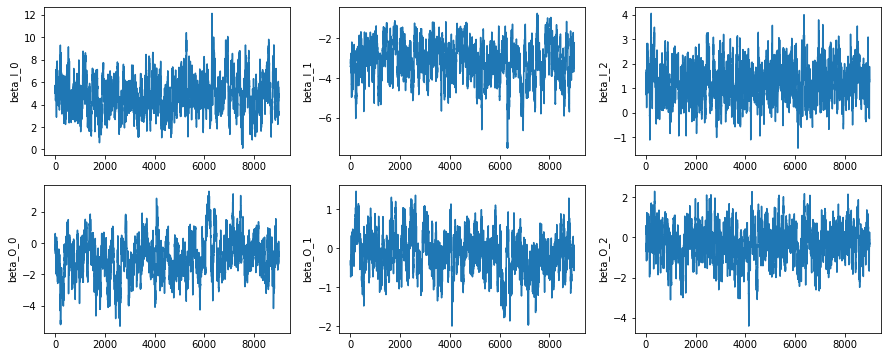

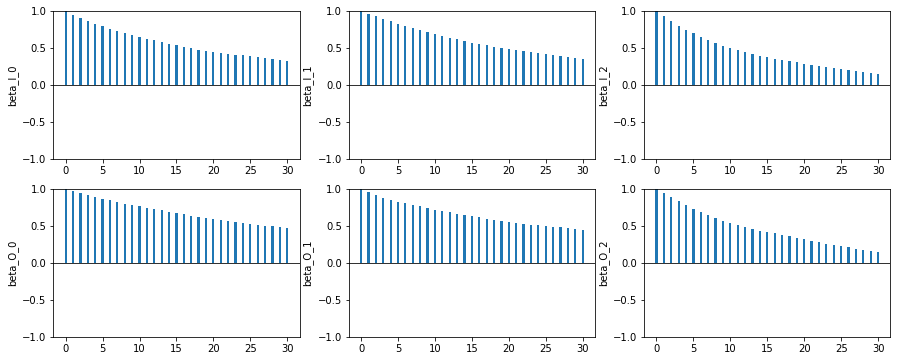

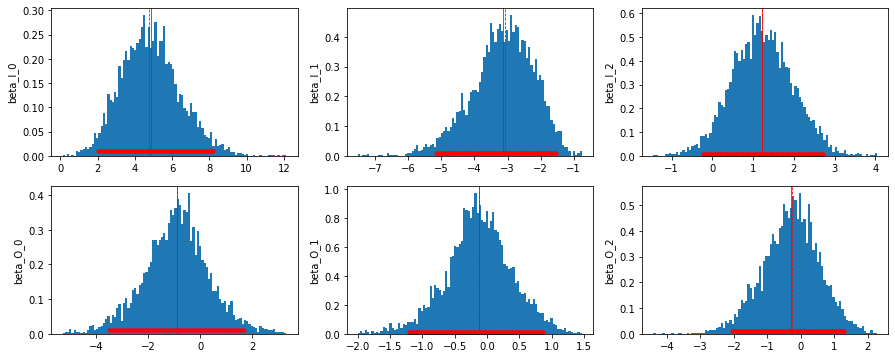

param 		 mean 	 var 	 95%CI
beta_I_0 		 4.859121 	 2.51862 	 [2.012889, 8.200905]
beta_I_1 		 -3.144712 	 0.882124 	 [-5.168238, -1.527995]
beta_I_2 		 1.228642 	 0.569843 	 [-0.233128, 2.723368]
beta_O_0 		 -0.915371 	 1.591633 	 [-3.522166, 1.672915]
beta_O_1 		 -0.126674 	 0.260304 	 [-1.20766, 0.869879]
beta_O_2 		 -0.29071 	 0.723081 	 [-2.052416, 1.303908]


In [13]:
# 2b
full_initial = [0,0,0,0,0,0]
full_inst = MCMC_Core.MCMC_MH(
                partial(log_posterior_with_normal_prior, y_x=data_inst.y_length_gender, sigma_vec=(10,10,10,10,10,10)),
                symmetric_proposal_placeholder,
                partial(normal_proposal_sampler, proposal_sigma_vec=[0.9, 0.3, 0.3, 0.35, 0.2, 0.3]),
                full_initial)
full_inst.generate_samples(50000, print_iter_cycle=10000)
full_diag = MCMC_Core.MCMC_Diag()
full_diag.set_mc_sample_from_MCMC_instance(full_inst)
full_diag.set_variable_names(["beta_I_0", "beta_I_1", "beta_I_2", "beta_O_0", "beta_O_1", "beta_O_2"])
full_diag.burnin(5000)
full_diag.thinning(5)

full_diag.show_traceplot((2,3))
full_diag.show_acf(30, (2,3))
full_diag.show_hist((2,3))
full_diag.print_summaries(6)

The same composition of results is there: traceplots, acf plots, and histograms (with mean/median(vertical red line/dashed lines) and 95% credible interval(horizontal red line)) for all parameters.
The table shows posterior means, variances, and 95% (centered) credible intervals based on the generated samples.

Next, I plot $\pi$ s, for male and female, in order.
The horizontal axis is 'length,' and the vertical axis indicates $\pi$.
Colors mean the same categories with (a). The black solid/dashed curves are posterior mean/median of $\pi_I$, the reds are of $\pi_O$, and the blues are of $\pi_F$, conditioned on each gender. Gray curves are 95% credible intervals' bounds.

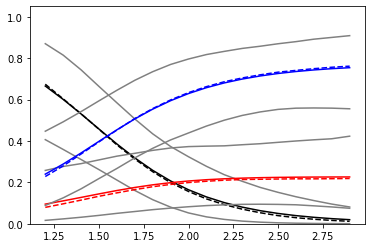

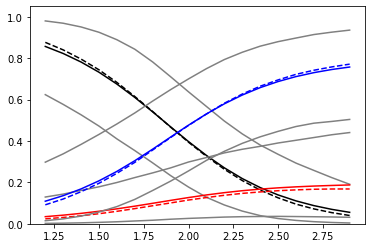

In [14]:
pi_plot(full_diag.MC_sample, (1.2, 3.0, 0.1), 0) #gender: 0: male, 1: female
pi_plot(full_diag.MC_sample, (1.2, 3.0, 0.1), 1)

Females' $\pi_O$ and $\pi_F$ are slightly lower than men's when values of the 'length' are low.
But the general trend seems the same.